In [8]:
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
import re

## Part 1: EDA

In [9]:
df = pd.read_csv('./glassdoor_jobs.csv')
print(df.shape)
df.head()

(1500, 12)


,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue
0,Data Scientist,-1,Job Overview\nA Data Scientist at ExploreLearn...,4.2,Cambium Learning Group\n4.3,Remote,1001 to 5000 Employees,2004,Company - Private,Primary & Secondary Schools,Education,$500 million to $1 billion (USD)
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe\n4.4,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD)
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM\n3.9,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD)
3,Data Scientist 2,Employer Provided Salary:$94K - $183K,The Microsoft 365 team is looking for a Data S...,4.3,Microsoft\n4.3,"Redmond, WA",10000+ Employees,1975,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD)
4,Entry Level Data Scientist 2023/2024,$48K - $78K (Glassdoor est.),"You may not realize it, but you’ve likely used...",3.9,CPChem\n3.9,"The Woodlands, TX",1001 to 5000 Employees,2000,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD)


In [10]:
# Drop duplicates revealed by EDA
df = df.drop_duplicates()

# Drop rows with missing salary estimate
df = df[df['Salary Estimate'] != '-1']

# Get state from non-remote locations
df['State'] = df['Location'].apply(lambda x: 'Remote' if x == 'Remote' else (x.split(', ')[1] if ', ' in x else '-1'))

# Fix issue where company rating appears alongside company name
def clean_company_name(name):
    if '\n' in name:
        return name.split('\n')[0].strip()
    else:
        return name.strip()

df['Company Name'] = df['Company Name'].apply(clean_company_name)

# Multiple listings from the same company --> non-iid
print(df['Company Name'].value_counts())

Company Name
-1                             9
Procter & Gamble               6
INTEL                          5
TikTok                         5
JPMorgan Chase & Co            4
                              ..
US Internal Revenue Service    1
Movable Ink                    1
LinQuest Corporation           1
AllocateRite                   1
The JAAW Group                 1
Name: count, Length: 553, dtype: int64


Job Title 0.010294117647058823
Salary Estimate 0.0
Job Description 0.008823529411764706
Rating 0.06764705882352941
Company Name 0.013235294117647059
Location 0.011764705882352941
Size 0.023529411764705882
Founded 0.17941176470588235
Type of ownership 0.023529411764705882
Industry 0.09558823529411764
Sector 0.09558823529411764
Revenue 0.023529411764705882
State 0.039705882352941174


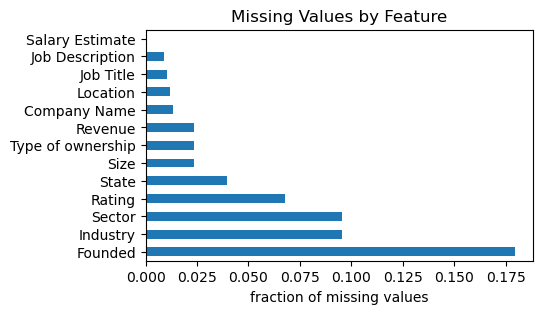

In [11]:
# Analyze missing data
missing_data = {}
for col in df.columns:
  if col in ['Rating', 'Founded']:
    num_missing = df[df[col] == -1].shape[0]
  else:
    num_missing = df[df[col] == '-1'].shape[0]
  prc_missing = num_missing / df.shape[0]
  missing_data[col] = prc_missing
  print(col, prc_missing)

plt.figure(figsize=(5,3))
series_data = pd.Series(missing_data).sort_values(ascending=False)
series_data.plot.barh()
plt.xlabel('fraction of missing values')
plt.title('Missing Values by Feature')
plt.show()

In [12]:
# Reformat 'Salary Estimate' column

def transform_salary(salary_string):
    # Assume 40hr/week for 52 weeks/year
    hours_per_year = 40 * 52

    # Case 1: annual salary range
    annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk] - \$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if annual_match:
        low = float(annual_match.group(1)) * 1000
        high = float(annual_match.group(2)) * 1000
        return low, high

    # Case 2: hourly rate range
    hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) - \$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if hourly_match:
        low_salary = float(hourly_match.group(1)) * hours_per_year
        high_salary = float(hourly_match.group(2)) * hours_per_year
        return low_salary, high_salary

    # Case 3: single annual salary value
    single_annual_match = re.match(r'.*\$(\d+(?:\.\d+)?)[Kk].*', salary_string)
    if single_annual_match:
        salary_value = float(single_annual_match.group(1).replace('K', '')) * 1000
        return salary_value, salary_value

    # Case 4: single hourly rate value
    single_hourly_match = re.match(r'.*\$(\d+(?:\.\d+)?) Per Hour.*', salary_string)
    if single_hourly_match:
        hourly_rate = float(single_hourly_match.group(1))
        low_salary = hourly_rate * hours_per_year
        high_salary = hourly_rate * hours_per_year
        return low_salary, high_salary
    
    # Print any cases we missed
    print(salary_string)
    return None, None

df['Low_Salary'], df['High_Salary'] = zip(*df['Salary Estimate'].apply(transform_salary))
df['Avg_Salary'] = (df['Low_Salary'] + df['High_Salary']) / 2
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
1,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0
2,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0


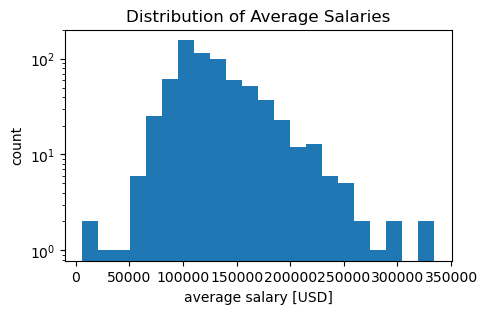

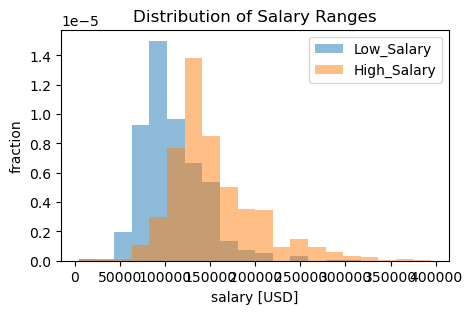

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary
105,Data Scientist 1,Employer Provided Salary:$5K - $7K,Requisition ID\nreq27082\n\nWorking Title\nDat...,3.8,University of New Mexico,"Albuquerque, NM",10000+ Employees,1889,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),NM,5000.0,7000.0,6000.0
123,Data Specialist,Employer Provided Salary:$30K - $35K,"Note: While this is a fully remote position, w...",4.1,Juristat,Remote,1 to 50 Employees,2012,Company - Private,Enterprise Software & Network Solutions,Information Technology,Unknown / Non-Applicable,Remote,30000.0,35000.0,32500.0
591,DATA SCIENTIST,Employer Provided Salary:$8K - $8K,DATA SCIENTIST\n\n\nReq #:\n220683\n\nDepartme...,4.2,University of Washington,"Seattle, WA",10000+ Employees,1861,College / University,Colleges & Universities,Education,$1 to $5 billion (USD),WA,8000.0,8000.0,8000.0


In [13]:
# Visualize distribution of salaries
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Salaries')
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

# Investigate outliers
df[df['High_Salary'] < 50000]

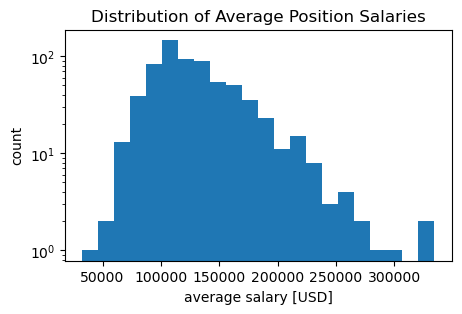

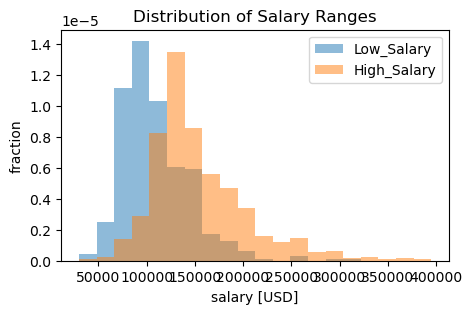

In [14]:
# The salary ranges corresponding to indices 105 and 591 are unreasonably low
# for a full-time data science position. They seem to correspond to student
# positions based on the employer name, so we will omit these from our analysis.

df.drop([105, 591], inplace=True)
df.reset_index(drop=True, inplace=True)
# Recreate histogram
plt.figure(figsize=(5,3))
df['Avg_Salary'].plot.hist(bins=int(1+3.322*np.log(len(df)))) # Sturge's rule
plt.semilogy()
plt.xlabel('average salary [USD]')
plt.ylabel('count')
plt.title('Distribution of Average Position Salaries')
plt.show()

categories = ['Low_Salary', 'High_Salary']
bin_range = (df['Low_Salary'].min(),df['High_Salary'].max())
plt.figure(figsize=(5,3))
for c in categories:
    plt.hist(df[c],alpha=0.5,label=c,range=bin_range,bins=20,density=True)
plt.legend()
plt.ylabel('fraction')
plt.xlabel('salary [USD]')
plt.title('Distribution of Salary Ranges')
plt.show()

In [15]:
# Transform 'Job Title' column

def get_job_type(title):
  if 'engineer' in title.lower():
    return 'Data Engineer'
  elif 'data scientist' in title.lower() or 'data science' in title.lower():
    return 'Data Scientist'
  elif 'analyst' in title.lower() or 'analytics' in title.lower():
    return 'Data Analyst'
  else:
    # print(title)
    return 'Other'

def get_level(title):
  if 'Entry Level' in title or 'College Graduate' in title:
    return 'Entry Level'
  elif 'Junior' in title or 'Jr. ' in title or 'Jr ' in title:
    return 'Junior'
  elif 'Senior' in title or 'Sr. ' in title or 'Sr ' in title:
    return 'Senior'
  elif 'Lead ' in title or 'Chief ' in title or 'Principal' in title:
    return 'Very Senior'
  else:
    return 'Unspecified'

df['Job Type'] = df['Job Title'].apply(get_job_type)
df['Experience Level'] = df['Job Title'].apply(get_level)
df.head(2)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,Information Technology,$5 to $10 billion (USD),CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level


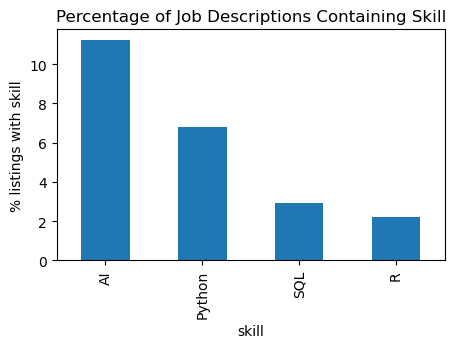

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Size,Founded,Type of ownership,Industry,...,State,Low_Salary,High_Salary,Avg_Salary,Job Type,Experience Level,Python,R,SQL,AI
0,2024 University Graduate - Data Scientist,Employer Provided Salary:$83K - $153K,Our Company\n\nChanging the world through digi...,4.4,Adobe,"San Jose, CA",10000+ Employees,1982,Company - Public,Computer Hardware Development,...,CA,83000.0,153000.0,118000.0,Data Scientist,Unspecified,1,1,1,0
1,Data Scientist – Entry Level 2024,Employer Provided Salary:$71K - $133K,Introduction\nRanked by Forbes as one of the w...,3.9,IBM,"Atlanta, GA",10000+ Employees,1911,Company - Public,Information Technology Support Services,...,GA,71000.0,133000.0,102000.0,Data Scientist,Entry Level,0,0,0,1


In [16]:
# Transform 'Job Description' column
df['Job Description'] = df['Job Description'].str.replace(r'\n', ' ')

# Create new columns using 'Job Description' column
skills_mapping = {
        "Python": ["python", "tensorflow", "pytorch", "pandas"],
        "R": ["r", "rstudio"],
        "SQL": ["sql", "postgresql", "mysql", "nosql"],
        "AI": ["ai", "artificial intelligence", "ml", "machine learning",
                                     "deep learning", "nlp", "natural language processing"],
    }

def create_skill_columns(df):
    for skill, aliases in skills_mapping.items():
        df[skill] = df['Job Description'].apply(lambda x: 1 if any(alias.lower() in x.lower().split() for alias in aliases) else 0)
    return df
df_skills = create_skill_columns(df)
percentages = df_skills[skills_mapping.keys()].mean() * 100
percentages_sorted = percentages.sort_values(ascending=False)

plt.figure(figsize=(5, 3))
percentages_sorted.plot.bar()
plt.ylabel('% listings with skill')
plt.xlabel('skill')
plt.title('Percentage of Job Descriptions Containing Skill')
plt.show()

df.head(2)

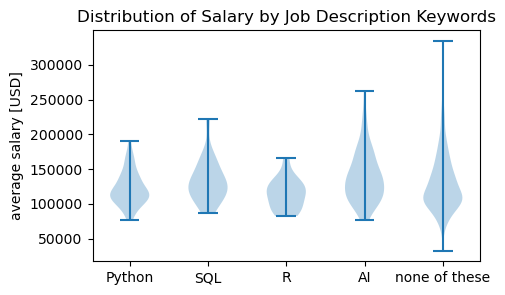

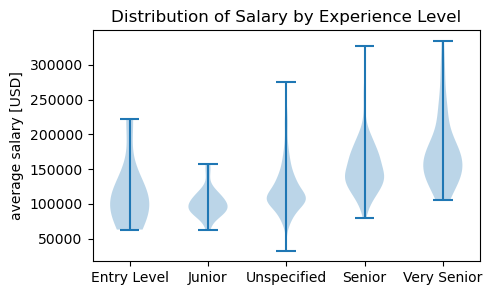

In [17]:
plt.figure(figsize=(5,3))
plt.violinplot([df[df['Python']==1]['Avg_Salary'].values,
                df[df['SQL']==1]['Avg_Salary'].values,
                df[df['R']==1]['Avg_Salary'].values,
                df[df['AI']==1]['Avg_Salary'].values,
                df[(df['Python']==0) & (df['R']==0) & (df['SQL']==0) & (df['AI']==0)]['Avg_Salary'].values])
plt.xticks([1,2,3,4,5],['Python', 'SQL', 'R', 'AI', 'none of these'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Job Description Keywords')
plt.show()

plt.figure(figsize=(5,3))
plt.violinplot([df[df['Experience Level']=='Entry Level']['Avg_Salary'].values,
                df[df['Experience Level']=='Junior']['Avg_Salary'].values,
                df[df['Experience Level']=='Unspecified']['Avg_Salary'].values,
                df[df['Experience Level']=='Senior']['Avg_Salary'].values,
                df[df['Experience Level']=='Very Senior']['Avg_Salary'].values
            ])
plt.xticks([1,2,3,4,5],['Entry Level','Junior','Unspecified','Senior','Very Senior'])
plt.ylabel('average salary [USD]')
plt.title('Distribution of Salary by Experience Level')
plt.show()

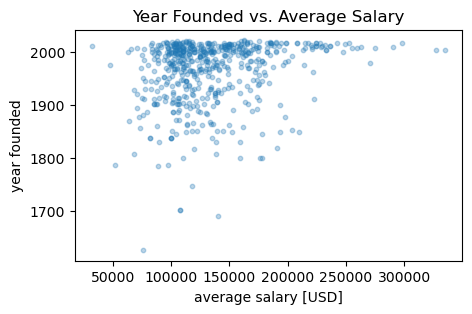

            Avg_Salary  Founded
Avg_Salary     1.00000  0.16503
Founded        0.16503  1.00000


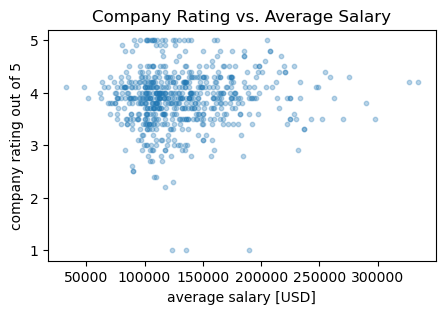

            Avg_Salary    Rating
Avg_Salary    1.000000  0.070715
Rating        0.070715  1.000000


In [18]:
# Compare continuous features to target

# plt.figure(figsize=(5,3))
df[df['Founded'] != -1].plot.scatter('Avg_Salary','Founded',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('year founded')
plt.title('Year Founded vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Founded']].corr())

# plt.figure(figsize=(5,3))
df[df['Rating'] != -1].plot.scatter('Avg_Salary','Rating',figsize=(5,3),alpha=0.3,s=10)
plt.xlabel('average salary [USD]')
plt.ylabel('company rating out of 5')
plt.title('Company Rating vs. Average Salary')
plt.show()
print(df[['Avg_Salary', 'Rating']].corr())

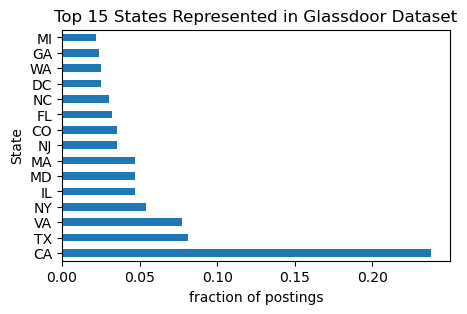

In [19]:
plt.figure(figsize=(5,3))
pd.value_counts(df[(df['State'] != '-1') & (df['State'] != 'Remote')]['State'],normalize=True).nlargest(15).plot.barh()
plt.xlabel('fraction of postings')
plt.title('Top 15 States Represented in Glassdoor Dataset')
plt.show()

In [20]:
# Group "Unknown" and missing values together in the same category

df['Size'] = df['Size'].replace('Unknown', '-1')
df['Type of ownership'] = df['Type of ownership'].replace('Unknown', '-1')
df['Revenue'] = df['Revenue'].replace('Unknown / Non-Applicable', '-1')

ftrs = ['Size', 'Type of ownership', 'Revenue']
for ftr in ftrs:
  print(df[ftr].value_counts())
  print('')

Size
10000+ Employees           237
1001 to 5000 Employees     118
1 to 50 Employees           71
51 to 200 Employees         68
-1                          55
201 to 500 Employees        44
5001 to 10000 Employees     43
501 to 1000 Employees       42
Name: count, dtype: int64

Type of ownership
Company - Private                 275
Company - Public                  263
Nonprofit Organization             37
Subsidiary or Business Segment     26
Government                         21
-1                                 18
College / University               16
Hospital                            8
Self-employed                       6
Private Practice / Firm             4
Contract                            4
Name: count, dtype: int64

Revenue
-1                                  259
$10+ billion (USD)                  153
$1 to $5 billion (USD)               69
$100 to $500 million (USD)           51
$5 to $25 million (USD)              35
$5 to $10 billion (USD)              33
$25 to $1

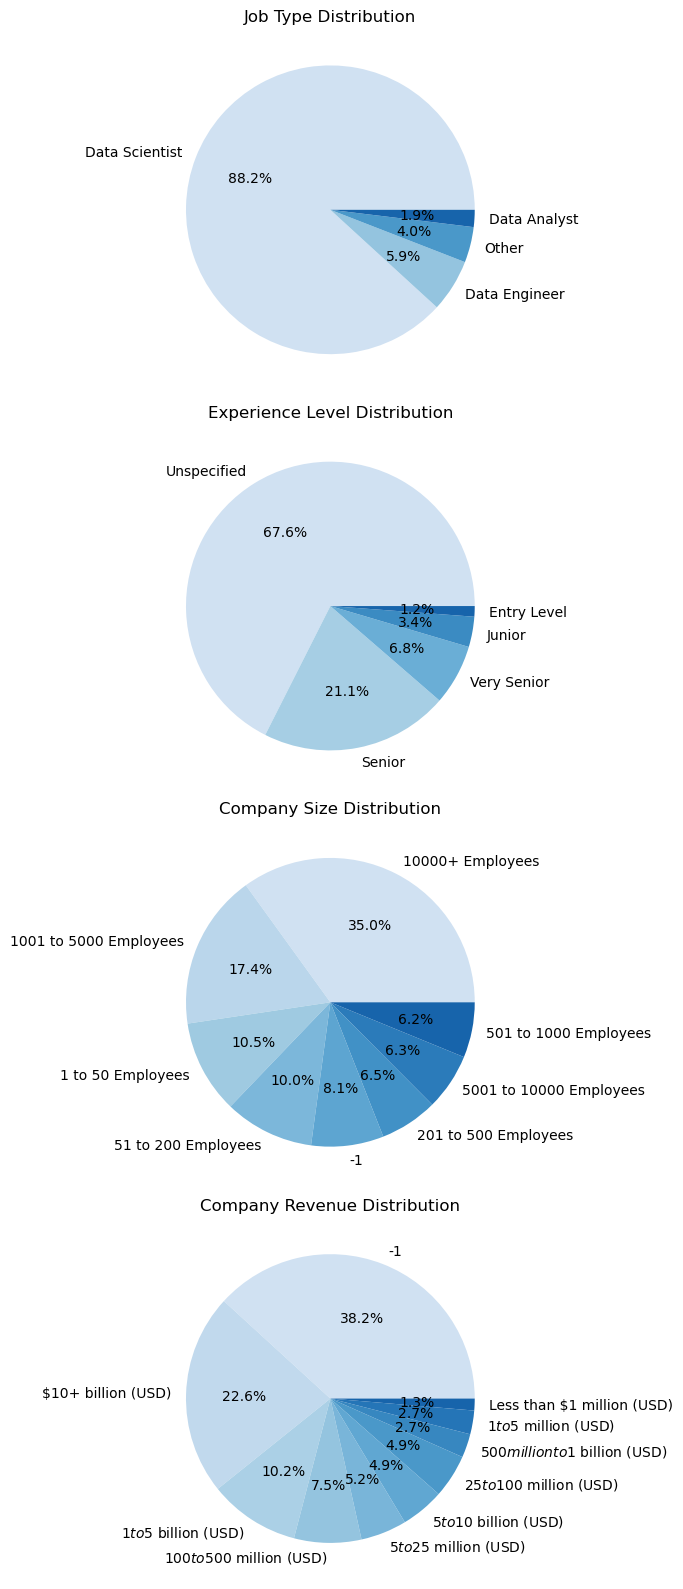

In [21]:
import matplotlib.pyplot as plt
from matplotlib.cm import Blues

# Set a common figsize for all plots
fig, axs = plt.subplots(4, 1, figsize=(16, 16))

# Job Type Distribution
value_counts = df['Job Type'].value_counts()
axs[0].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[0].set_title('Job Type Distribution')

# Experience Level Distribution
value_counts = df['Experience Level'].value_counts()
axs[1].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[1].set_title('Experience Level Distribution')

# Company Size Distribution
value_counts = df['Size'].value_counts()
axs[2].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[2].set_title('Company Size Distribution')

# Company Revenue Distribution
value_counts = df['Revenue'].value_counts()
axs[3].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=Blues(np.linspace(0.2, 0.8, len(value_counts))))
axs[3].set_title('Company Revenue Distribution')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Part 2: Preprocessing

In [22]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupShuffleSplit

random_state = 42

# -1 represents missing values
df.replace(-1, np.nan, inplace=True)

# drop columns that are not useful for our analysis
to_exclude = ['Job Title', 'Job Description', 'Salary Estimate', 'Low_Salary', 'High_Salary']
df.drop(columns=to_exclude, inplace=True)

# the target variable
y = df['Avg_Salary']
df.drop(columns=['Avg_Salary'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(X.shape)
# the feature names
groups = df['Company Name']
df.drop(columns=['Company Name'],inplace=True)
ftrs = df.columns

# let's split to train, CV, and test
# X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
# X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

# USE GROUP SPLIT INSTEAD
X = df
gss = GroupShuffleSplit(n_splits=1, train_size=0.6, random_state=random_state)
gss_second_split = GroupShuffleSplit(n_splits=1, train_size=0.5, random_state=random_state)

for train_idx, other_idx in gss.split(X, y, groups):
    X_train = X.iloc[train_idx]
    y_train = y.iloc[train_idx]
    X_other = X.iloc[other_idx]
    y_other = y.iloc[other_idx]
    second_split_groups = groups.iloc[other_idx]
    for val_idx, test_idx in gss_second_split.split(X_other, y_other, second_split_groups):
        X_CV, y_CV = X_other.iloc[val_idx], y_other.iloc[val_idx]
        X_test, y_test = X_other.iloc[test_idx], y_other.iloc[test_idx]

print(X_train.shape)
print(X_CV.shape)
print(X_test.shape)

(678, 16)
(397, 15)
(142, 15)
(139, 15)


In [23]:
X_train.head()

,Rating,Location,Size,Founded,Type of ownership,Industry,Sector,Revenue,State,Job Type,Experience Level,Python,R,SQL,AI
1,3.9,"Atlanta, GA",10000+ Employees,1911.0,Company - Public,Information Technology Support Services,Information Technology,$10+ billion (USD),GA,Data Scientist,Entry Level,0,0,0,1
2,4.3,"Redmond, WA",10000+ Employees,1975.0,Company - Public,Computer Hardware Development,Information Technology,$10+ billion (USD),WA,Data Scientist,Unspecified,0,0,0,0
3,3.9,"The Woodlands, TX",1001 to 5000 Employees,2000.0,Company - Private,Chemical Manufacturing,Manufacturing,$10+ billion (USD),TX,Data Scientist,Entry Level,0,0,0,0
4,NaN,Remote,1 to 50 Employees,NaN,Company - Public,-1,-1,-1,Remote,Data Scientist,Unspecified,0,0,0,1
6,3.4,Remote,10000+ Employees,1902.0,Nonprofit Organization,Health Care Services & Hospitals,Healthcare,-1,Remote,Data Scientist,Unspecified,0,0,0,0


In [24]:
common_rows = pd.merge(X_train, X_test, on=list(X_test.columns), how='inner')

print(common_rows)

   Rating    Location              Size  Founded  Type of ownership  \
0     3.5  Austin, TX  10000+ Employees   1952.0  Company - Private   
1     3.6    Troy, MI  10000+ Employees   1887.0  Company - Private   

       Industry                                       Sector  \
0  Construction  Construction, Repair & Maintenance Services   
1    Publishing                        Media & Communication   

                            Revenue State        Job Type Experience Level  \
0  $500 million to $1 billion (USD)    TX  Data Scientist      Unspecified   
1                $10+ billion (USD)    MI  Data Scientist      Unspecified   

   Python  R  SQL  AI  
0       0  0    0   0  
1       0  0    0   0  


In [25]:
# # -1 represents missing values
# df.replace(-1, np.nan, inplace=True)

# # drop columns that are not useful for our analysis
# to_exclude = ['Job Title', 'Job Description', 'Salary Estimate', 'Low_Salary', 'High_Salary']
# df.drop(columns=to_exclude, inplace=True)

# # the target variable
# y = df['Avg_Salary']
# df.drop(columns=['Avg_Salary'],inplace=True)
# # the unprocessed feature matrix
# X = df.values
# print(X.shape)
# # the feature names
# ftrs = df.columns


In [26]:
# collect the various features
cat_ftrs = ['Location', 'State', 'Type of ownership', 'Industry', 'Job Type']
ordinal_ftrs = ['Size', 'Revenue', 'Experience Level']
ordinal_cats = [['-1', '1 to 50 Employees', '51 to 200 Employees', '201 to 500 Employees',
                '501 to 1000 Employees', '1001 to 5000 Employees', '5001 to 10000 Employees',
                '10000+ Employees'],
                ['-1', 'Less than $1 million (USD)', '$1 to $5 million (USD)', '$5 to $25 million (USD)',
                '$25 to $100 million (USD)', '$100 to $500 million (USD)',
                '$500 million to $1 billion (USD)', '$1 to $5 billion (USD)',
                '$5 to $10 billion (USD)', '$10+ billion (USD)'],
                ['Entry Level', 'Junior', 'Unspecified', 'Senior', 'Very Senior']]
num_ftrs = ['Rating', 'Founded', 'Python', 'R', 'SQL', 'AI']

In [27]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

# Splitting

In [28]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
final_scaler = StandardScaler()
X_prep = final_scaler.fit_transform(X_prep)
# collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(df_train.shape)

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = final_scaler.transform(df_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(df_CV.shape)

# transform the test
df_test = preprocessor.transform(X_test)
df_test = final_scaler.transform(df_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(df_test.shape)

print('data dimensions:',df_train.shape)
perc_missing_per_ftr = df_train.isnull().sum(axis=0)/df_train.shape[0]
print('fraction of missing values in features:')
print(perc_missing_per_ftr[perc_missing_per_ftr > 0])
frac_missing = sum(df_train.isnull().sum(axis=1)!=0)/df_train.shape[0]
print('fraction of points with missing values:',frac_missing)

(397, 289)
(142, 289)
(139, 289)
data dimensions: (397, 289)
fraction of missing values in features:
num__Rating     0.062972
num__Founded    0.171285
dtype: float64
fraction of points with missing values: 0.1712846347607053


### Multivariate Imputation

In [29]:
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import LinearRegression

# imputer = IterativeImputer(estimator = RandomForestRegressor(n_estimators=1), random_state=42)
# # imputer = IterativeImputer(estimator = LinearRegression(), random_state=42)
# X_impute = imputer.fit_transform(df_train)
# df_train_imp = pd.DataFrame(data=X_impute, columns = df_train.columns)

# df_CV_imp = pd.DataFrame(data=imputer.transform(df_CV), columns = df_train.columns)
# df_test_imp = pd.DataFrame(data=imputer.transform(df_test), columns = df_train.columns)

### XGBoost

In [30]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
            #   "reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
            #   "reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
              "missing": [np.nan], 
            #   "max_depth": [1,3,10,30,100],
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

XGB = xgboost.XGBRegressor()
XGB.set_params(**ParameterGrid(param_grid)[0]) # ONLY THE ONE MODEL IS TRAINED HERE!
XGB.fit(df_train,y_train,early_stopping_rounds=50,eval_set=[(df_CV, y_CV)], verbose=False)
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 34341.28539696448
the test RMSE: 28415.257621065557
the test R2: 0.11374314338524238


### Reduced-features model

In [31]:
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
   
def xgb_model(X_train, Y_train, X_CV, y_CV, X_test, y_test, verbose=1):

    # make into row vectors to avoid an obnoxious sklearn/xgb warning
    Y_train = np.reshape(np.array(Y_train), (1, -1)).ravel()
    y_CV = np.reshape(np.array(y_CV), (1, -1)).ravel()
    y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    XGB = xgboost.XGBRegressor(n_jobs=1)
    
    # find the best parameter set
    param_grid = {"learning_rate": [0.03],
                  "n_estimators": [10000],
                  "seed": [0],
                  #"reg_alpha": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  #"reg_lambda": [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
                  "missing": [np.nan], 
                  #"max_depth": [1,3,10,30,100,],
                  "colsample_bytree": [0.9],              
                  "subsample": [0.66]}

    pg = ParameterGrid(param_grid)

    scores = np.zeros(len(pg))

    for i in range(len(pg)):
        if verbose >= 5:
            print("Param set " + str(i + 1) + " / " + str(len(pg)))
        params = pg[i]
        XGB.set_params(**params)
        eval_set = [(X_CV, y_CV)]
        XGB.fit(X_train, Y_train,
                early_stopping_rounds=50, eval_set=eval_set, verbose=False)# with early stopping
        y_CV_pred = XGB.predict(X_CV, ntree_limit=XGB.best_ntree_limit)
        scores[i] = mean_squared_error(y_CV,y_CV_pred)

    best_params = np.array(pg)[scores == np.max(scores)]
    if verbose >= 4:
        print('Test set max score and best parameters are:')
        print(np.max(scores))
        print(best_params)

    # test the model on the test set with best parameter set
    XGB.set_params(**best_params[0])
    XGB.fit(X_train,Y_train,
            early_stopping_rounds=50,eval_set=eval_set, verbose=False)
    y_test_pred = XGB.predict(X_test, ntree_limit=XGB.best_ntree_limit)

    if verbose >= 1:
        print ('The MSE is:',mean_squared_error(y_test,y_test_pred))
    if verbose >= 2:
        print ('The predictions are:')
        print (y_test_pred)
    if verbose >= 3:
        print("Feature importances:")
        print(XGB.feature_importances_)

    return (mean_squared_error(y_test,y_test_pred), y_test_pred, XGB.feature_importances_)

# Function: Reduced-feature XGB model
# all the inputs need to be pandas DataFrame
def reduced_feature_xgb(X_train, Y_train, X_CV, y_CV, X_test, y_test):
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run XGB
        sub_y_test_pred = xgb_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, verbose=0)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:',np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
               
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)
    return total_RMSE, total_R2

In [32]:
mask = df_test[df_test.columns].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 3 patterns, we will train 3 models
for i in range(len(counts)):
    print(counts[i])

(3, 289)
111
15
13


In [33]:
RMSE, R2 = reduced_feature_xgb(df_train, y_train, df_CV, y_CV, df_test, y_test)
print('final RMSE:', RMSE)
print('final R2:', R2)

there are 3 unique missing value patterns.
working on unique pattern 0


   RMSE: 28864.929149329288
working on unique pattern 1
   RMSE: 24054.512648513904
working on unique pattern 2
   RMSE: 32618.14997449615
final RMSE: 28762.735789641905
final R2: 0.09193529362136621


# FRESH

In [34]:
mask = df[df.columns].isnull()

unique_rows, counts = np.unique(mask, axis=0,return_counts=True)
print(unique_rows.shape) # 6 patterns, we will train 6 models
for i in range(len(counts)):
    # print True feature names
    for j in range(len(unique_rows[i])):
        if unique_rows[i][j] == True:
            print(ftrs[j])
    print(unique_rows[i],counts[i])

(4, 15)
[False False False False False False False False False False False False
 False False False] 555
Founded
[False False False  True False False False False False False False False
 False False False] 77
Rating
[ True False False False False False False False False False False False
 False False False] 1
Rating
Founded
[ True False False  True False False False False False False False False
 False False False] 45


In [52]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupShuffleSplit
# import elastic net
from sklearn.linear_model import ElasticNet
import shap

def best_model(X_train, y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid, verbose=1):

    k_fold = KFold(n_splits=4, shuffle=True, random_state=42)

    # gss = GroupShuffleSplit(n_splits=4, train_size=0.75, random_state=42)
    #gss.split(X_train, y_train, groups=X_train['']
        
    grid = GridSearchCV(ML_algo, param_grid=param_grid, cv=k_fold, scoring='neg_root_mean_squared_error')
    grid.fit(X_train, y_train)
    print(grid.best_params_)

    # best_models.append(grid.best_estimator_)
    test_score = -grid.score(X_test, y_test)
    # test_scores.append(-test_score)
    y_test_pred = grid.predict(X_test)

    ## FEATURE IMPORTANCE CODE ##
    if isinstance(ML_algo, ElasticNet):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        # coefs = grid.best_estimator_[-1].coef_[0]
        coefs = grid.best_estimator_.coef_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    if isinstance(ML_algo, svm.SVR):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.coef_[0]
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    if isinstance(ML_algo, xgboost.XGBRegressor):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()
    
    if isinstance(ML_algo, RandomForestRegressor):
        feature_names = X_train.columns
        print('test score:',grid.score(X_test,y_test))
        coefs = grid.best_estimator_.feature_importances_
        sorted_indcs = np.argsort(np.abs(coefs))
        
        plt.figure(figsize=(10,6))
        plt.rcParams.update({'font.size': 11})
        plt.barh(np.arange(10),coefs[sorted_indcs[-10:]])
        plt.yticks(np.arange(10),feature_names[sorted_indcs[-10:]])
        plt.xlabel('coefficient')
        plt.title('all scaled')
        plt.tight_layout()
        # plt.savefig('figures/LR_coefs_scaled.png',dpi=300)
        plt.show()

    return (test_score, y_test_pred, grid.best_estimator_)

# Create a generic reduced_feature function
# all the inputs need to be pandas DataFrame
def reduced_feature(X_train, Y_train, X_CV, y_CV, X_test, y_test, ML_algo, param_grid):

    counter = 0
    
    # find all unique patterns of missing value in test set
    mask = X_test.isnull()
    unique_rows = np.array(np.unique(mask, axis=0))
    all_y_test_pred = pd.DataFrame()

    best_mods = []
    
    print('there are', len(unique_rows), 'unique missing value patterns.')
    
    # divide test sets into subgroups according to the unique patterns
    for i in range(len(unique_rows)):
        print ('working on unique pattern', i)
        ## generate X_test subset that matches the unique pattern i
        sub_X_test = pd.DataFrame()
        sub_y_test = pd.Series(dtype=float)
        for j in range(len(mask)): # check each row in mask
            row_mask = np.array(mask.iloc[j])
            if np.array_equal(row_mask, unique_rows[i]): # if the pattern matches the ith unique pattern

                sub_X_test = pd.concat([sub_X_test,X_test.iloc[[j]]])# append the according X_test row j to the subset
                sub_y_test = pd.concat([sub_y_test, y_test.iloc[[j]]])# append the according y_test row j

        sub_X_test = sub_X_test[X_test.columns[~unique_rows[i]]]
        
        ## choose the according reduced features for subgroups
        sub_X_train = pd.DataFrame()
        sub_Y_train = pd.DataFrame()
        sub_X_CV = pd.DataFrame()
        sub_y_CV = pd.DataFrame()
        # 1.cut the feature columns that have nans in the according sub_X_test
        sub_X_train = X_train[X_train.columns[~unique_rows[i]]]
        sub_X_CV = X_CV[X_CV.columns[~unique_rows[i]]]
        # 2.cut the rows in the sub_X_train and sub_X_CV that have any nans
        sub_X_train = sub_X_train.dropna()
        sub_X_CV = sub_X_CV.dropna()   
        # 3.cut the sub_Y_train and sub_y_CV accordingly
        sub_Y_train = Y_train.iloc[sub_X_train.index]
        sub_y_CV = y_CV.iloc[sub_X_CV.index]
        
        # run ML algorithm
        sub_y_test_pred = best_model(sub_X_train, sub_Y_train, sub_X_CV, 
                                       sub_y_CV, sub_X_test, sub_y_test, ML_algo, param_grid, verbose=0)
        best_mod = sub_y_test_pred[2]
        best_mods.append(best_mod)
        sub_y_test_pred = pd.DataFrame(sub_y_test_pred[1],columns=['sub_y_test_pred'],
                                          index=sub_y_test.index)
        print('   RMSE:', np.sqrt(mean_squared_error(sub_y_test,sub_y_test_pred)))
        # collect the test predictions
        all_y_test_pred = pd.concat([all_y_test_pred, sub_y_test_pred])

        # ## FEATURE IMPORTANCE CODE ##
        # test_score = best_mod.score(sub_X_test,sub_y_test)
        # # ftr_names = df_train.columns
        # ftr_names = sub_X_train.columns

        # nr_runs = 10
        # scores = np.zeros([len(ftr_names),nr_runs])

        # for i in range(len(ftr_names)):
        #     # print('shuffling '+str(ftr_names[i]))
        #     acc_scores = []
        #     for j in range(nr_runs):
        #         X_test_shuffled = sub_X_test.copy()
        #         X_test_shuffled[ftr_names[i]] = np.random.permutation(sub_X_test[ftr_names[i]].values)
        #         acc_scores.append(best_mod.score(X_test_shuffled,sub_y_test))
        #     # print('   shuffled test score:',np.around(np.mean(acc_scores),3),'+/-',np.around(np.std(acc_scores),3))
        #     scores[i] = acc_scores
        #     # sorted_indcs = np.argsort(np.mean(scores,axis=1))[::-1]
        #     sorted_indcs = np.argsort(np.mean(scores,axis=1))[-10:][::-1]

        # plt.rcParams.update({'font.size': 11})
        # plt.figure(figsize=(5,3))
        # plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
        # plt.axvline(test_score,label='test score')
        # plt.title("Permutation Importances (test set)")
        # plt.xlabel('score with perturbed feature')
        # plt.legend()
        # plt.tight_layout()
        # plt.show()

        if counter == 0:
            shap.initjs() # required for visualizations later on
            explainer = shap.Explainer(best_mod.predict, sub_X_train)
            shap_values = explainer(sub_X_test)
            # visualize the first prediction's explanation
            shap.plots.waterfall(shap_values[0])
        # counter += 1
        
    # rank the final y_test_pred according to original y_test index
    all_y_test_pred = all_y_test_pred.sort_index()
    y_test = y_test.sort_index()
    
    # get global RMSE
    total_RMSE = np.sqrt(mean_squared_error(y_test,all_y_test_pred))
    total_R2 =  r2_score(y_test,all_y_test_pred)

    # Make a scatterplot of true vs predicted values
    plt.figure(figsize=(5,3))
    plt.scatter(y_test, all_y_test_pred)
    plt.xlabel('true values')
    plt.ylabel('predicted values')
    plt.title('true vs predicted values')
    plt.tight_layout()
    plt.show()

    ## LOCAL FEATURE IMPORTANCE CODE ##


    return total_RMSE, total_R2, best_mods

In [36]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_params = {'max_depth': [1, 3, 10, 30, None],
             'max_features': [0.25, 0.5, 0.75, 1.0]}

svr_model = SVR(kernel='linear')
svr_params = {'gamma': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
              'C': [1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]}

knn_model = KNeighborsRegressor()
knn_params = {"n_neighbors": range(1, 21),
              "weights": ['uniform', 'distance']}

elastic_model = ElasticNet()
elastic_params = {'alpha': [1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3],
                  'l1_ratio': np.linspace(0, 1, 5)}

linreg_model = LinearRegression()
linreg_params = {}

In [37]:
df_train.head()

,num__Rating,num__Founded,num__Python,num__R,num__SQL,num__AI,"cat__Location_Agoura Hills, CA","cat__Location_Alameda, CA","cat__Location_Allentown, NJ","cat__Location_Anaheim, CA",...,cat__Industry_Transportation Equipment Manufacturing,cat__Industry_Video Game Publishing,cat__Industry_Wholesale,cat__Job Type_Data Analyst,cat__Job Type_Data Engineer,cat__Job Type_Data Scientist,cat__Job Type_Other,ord__Size,ord__Revenue,ord__Experience Level
0,-0.011296,-0.994082,-0.236328,-0.123876,-0.160748,2.869243,-0.050252,-0.050252,-0.050252,-0.050252,...,-0.123876,-0.152302,-0.087259,-0.160748,-0.230327,0.348524,-0.183995,1.088035,1.362383,-3.384897
1,0.829125,0.113751,-0.236328,-0.123876,-0.160748,-0.348524,-0.050252,-0.050252,-0.050252,-0.050252,...,-0.123876,-0.152302,-0.087259,-0.160748,-0.230327,0.348524,-0.183995,1.088035,1.362383,-0.457219
2,-0.011296,0.546498,-0.236328,-0.123876,-0.160748,-0.348524,-0.050252,-0.050252,-0.050252,-0.050252,...,-0.123876,-0.152302,-0.087259,-0.160748,-0.230327,0.348524,-0.183995,0.252542,1.362383,-3.384897
3,NaN,NaN,-0.236328,-0.123876,-0.160748,2.869243,-0.050252,-0.050252,-0.050252,-0.050252,...,-0.123876,-0.152302,-0.087259,-0.160748,-0.230327,0.348524,-0.183995,-1.418445,-1.076392,-0.457219
4,-1.061822,-1.149871,-0.236328,-0.123876,-0.160748,-0.348524,-0.050252,-0.050252,-0.050252,-0.050252,...,-0.123876,-0.152302,-0.087259,-0.160748,-0.230327,0.348524,-0.183995,1.088035,-1.076392,-0.457219


# Elastic Net

there are 3 unique missing value patterns.
working on unique pattern 0
{'alpha': 1000.0, 'l1_ratio': 1.0}
test score: -27096.721463156915


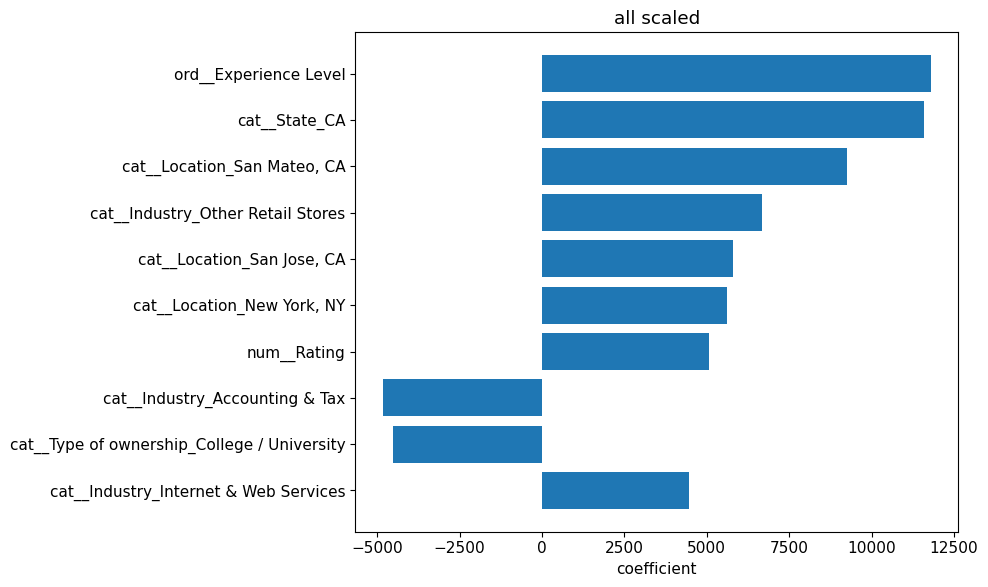

   RMSE: 27096.721463156915
working on unique pattern 1
{'alpha': 1.0, 'l1_ratio': 0.5}
test score: -23351.347957564278


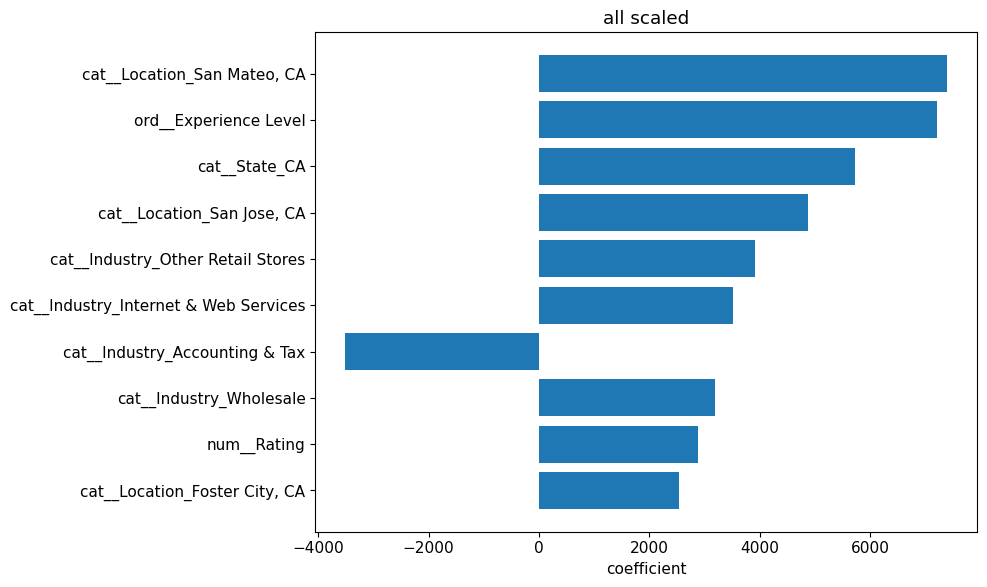

   RMSE: 23351.347957564278
working on unique pattern 2
{'alpha': 1.0, 'l1_ratio': 0.25}
test score: -28557.399309592874


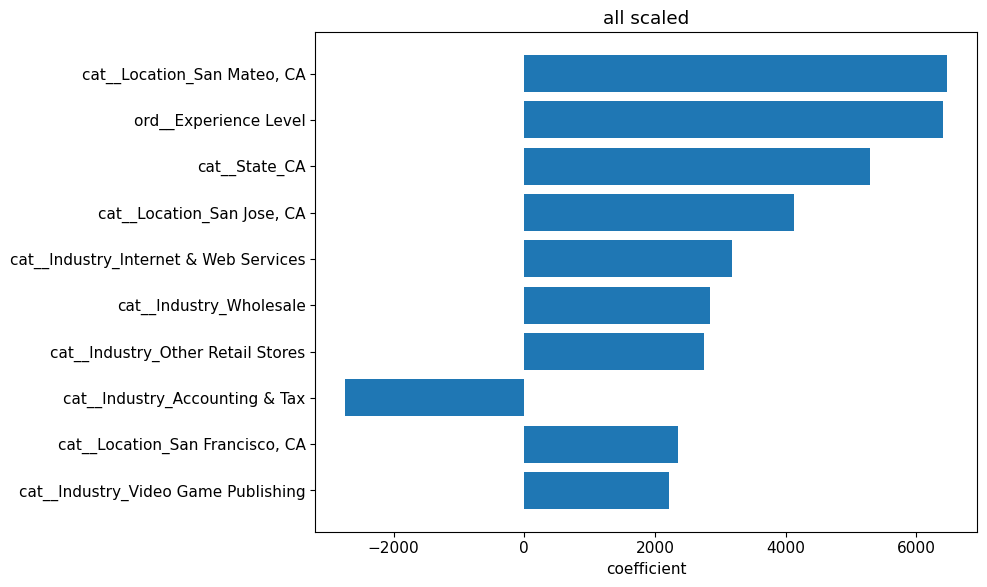

   RMSE: 28557.399309592874


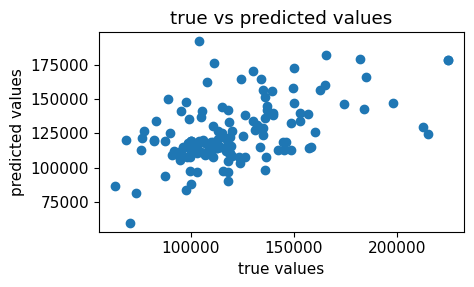

ValueError: max_evals=500 is too low for the Permutation explainer, it must be at least 2 * num_features + 1 = 579!

In [47]:
RMSE, R2, best_elastic = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, elastic_model, elastic_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# KNN Regressor

there are 3 unique missing value patterns.
working on unique pattern 0
{'n_neighbors': 6, 'weights': 'distance'}
   RMSE: 33549.243080155815


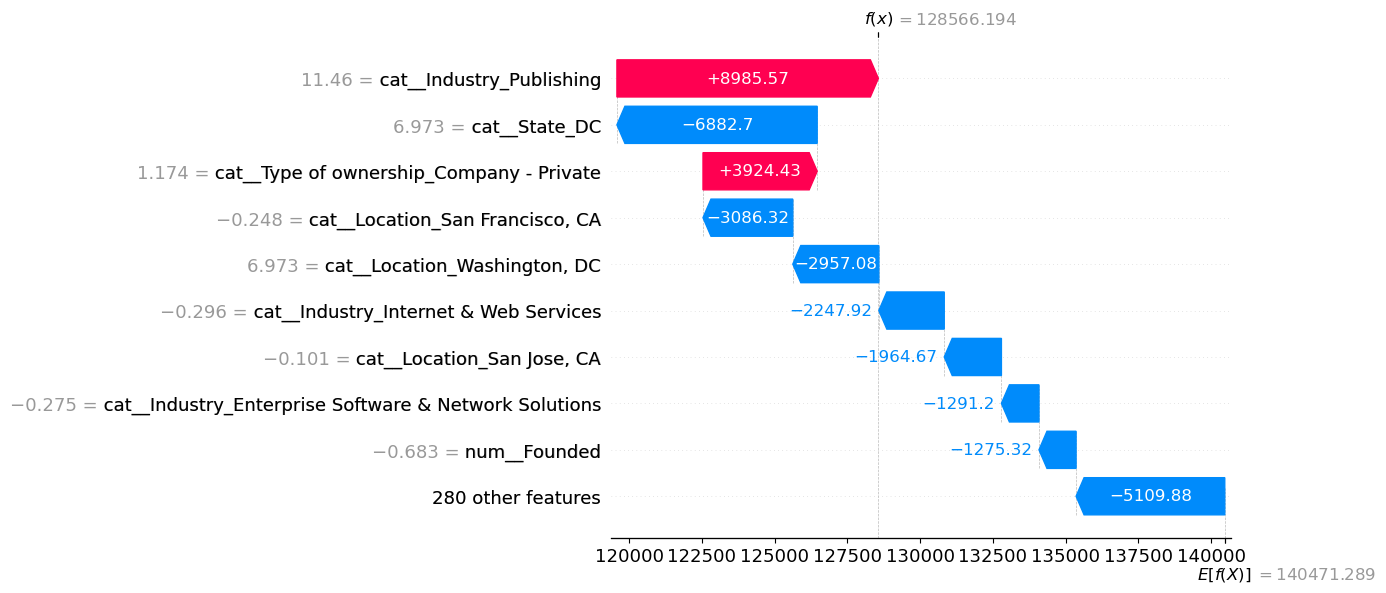

working on unique pattern 1
{'n_neighbors': 7, 'weights': 'distance'}
   RMSE: 39640.06388741286


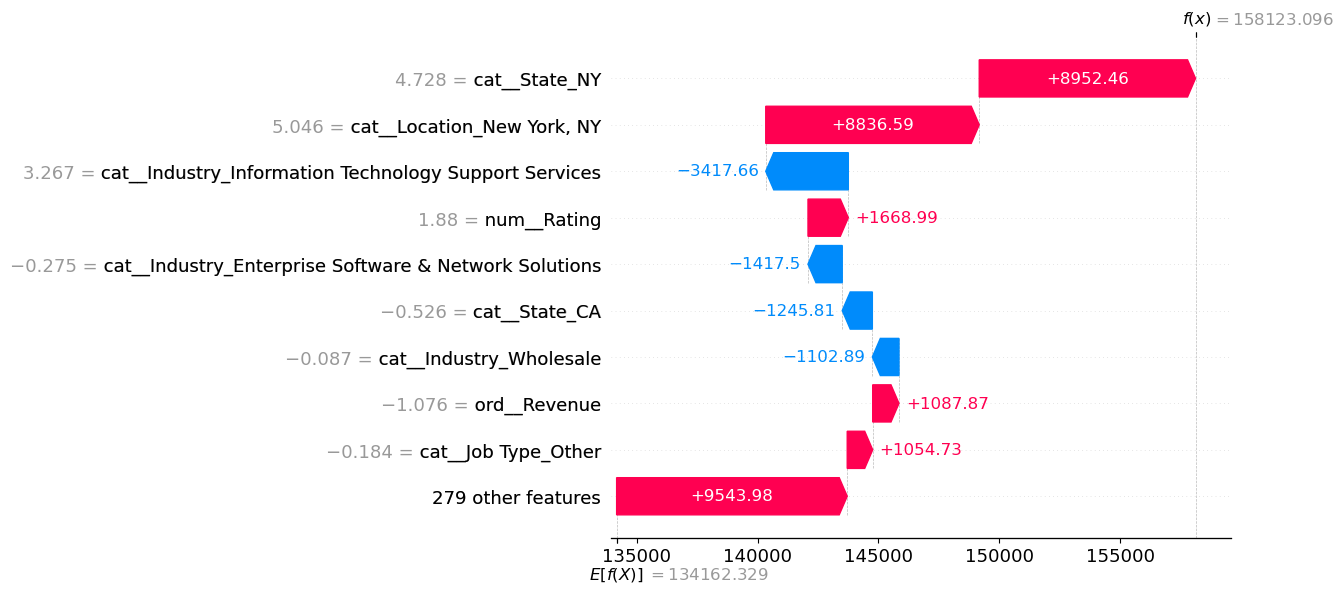

working on unique pattern 2
{'n_neighbors': 7, 'weights': 'distance'}
   RMSE: 30022.49114274738


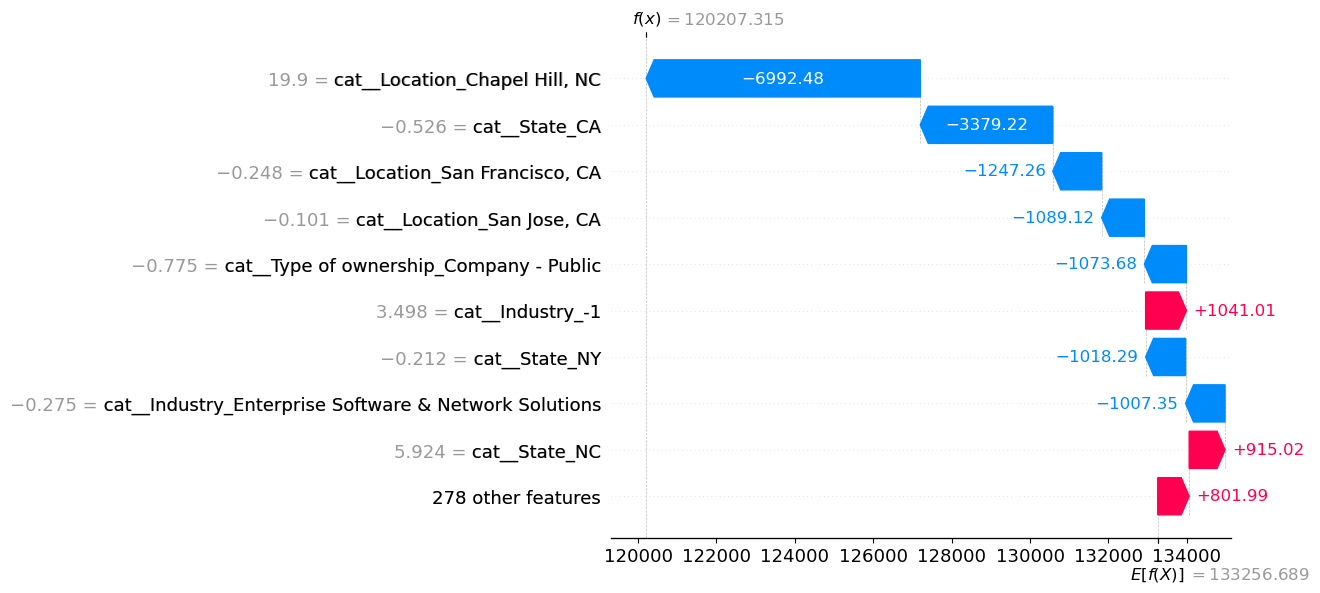

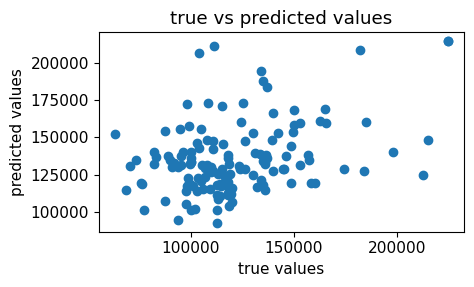

final RMSE: 33951.277997082376
final R2: -0.265227625291921


In [53]:
RMSE, R2, best_knn = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, knn_model, knn_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# Vanilla Linear Regression

In [ ]:
# RMSE, R2, best_vanilla = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, linreg_model, linreg_params)
# print('final RMSE:', RMSE)
# print('final R2:', R2)

# Random Forest

there are 3 unique missing value patterns.
working on unique pattern 0


{'max_depth': 30, 'max_features': 0.25}
test score: -27650.68556659211


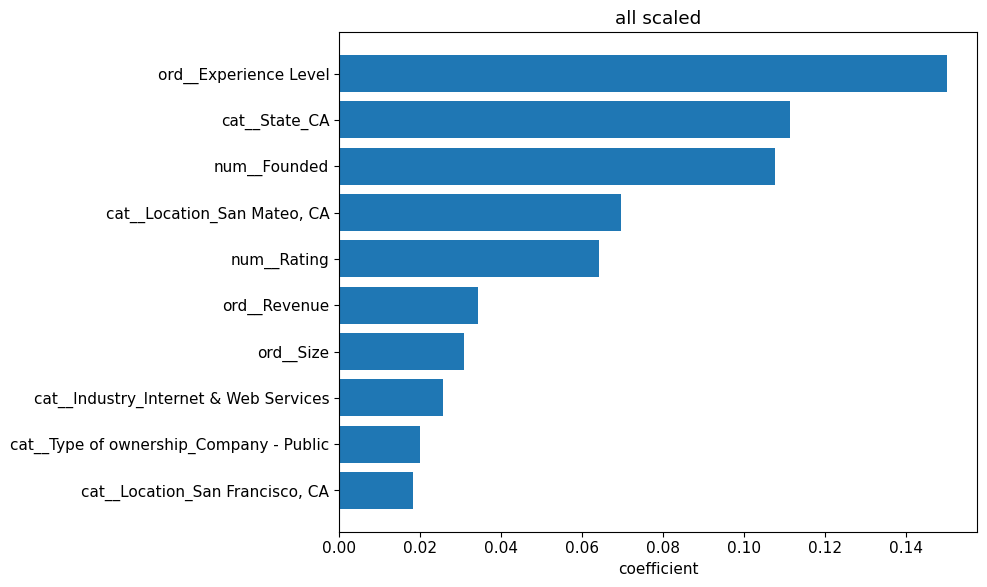

   RMSE: 27650.68556659211
working on unique pattern 1
{'max_depth': None, 'max_features': 0.25}
test score: -20438.269526112173


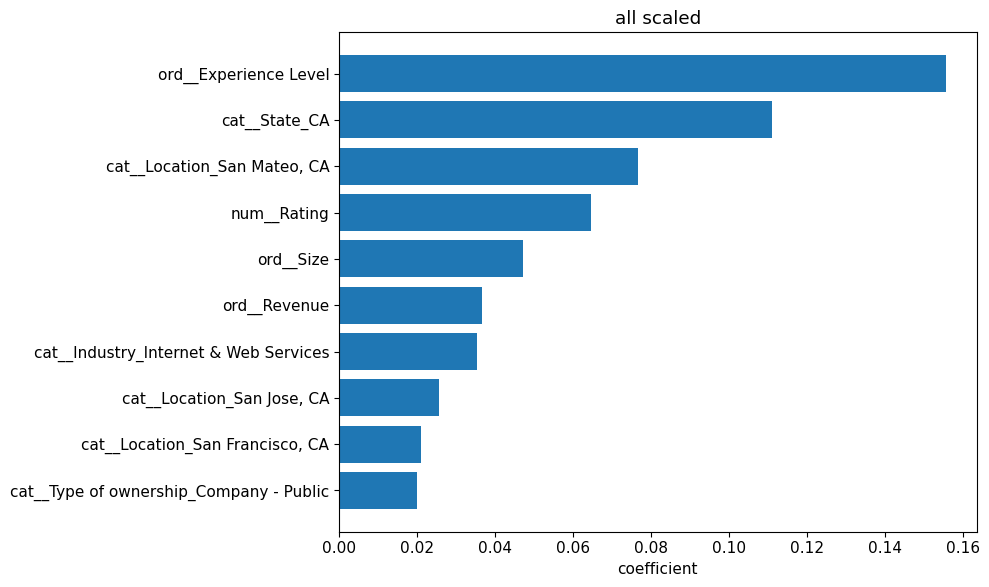

   RMSE: 20438.269526112173
working on unique pattern 2
{'max_depth': 30, 'max_features': 0.25}
test score: -32854.27866846501


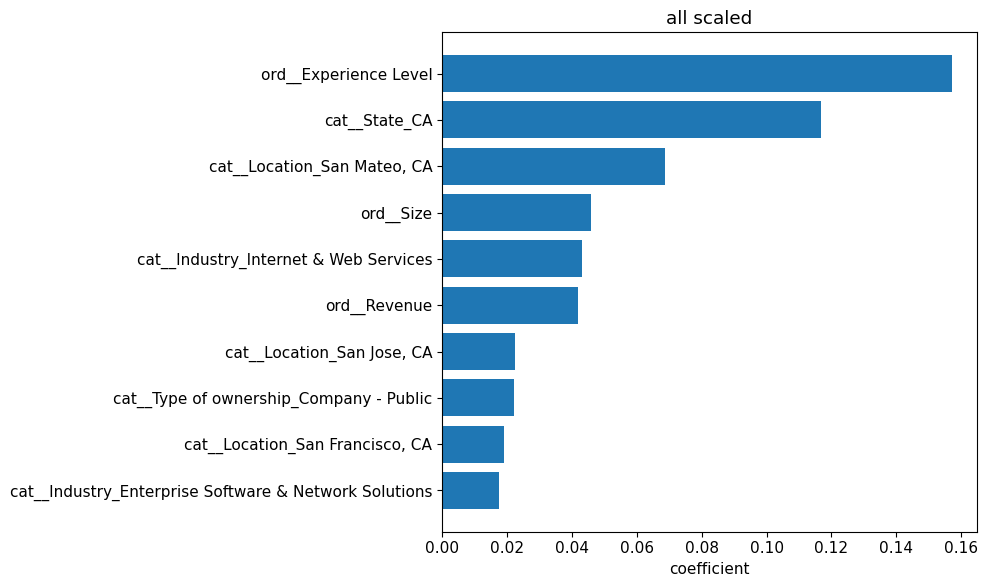

   RMSE: 32854.27866846501


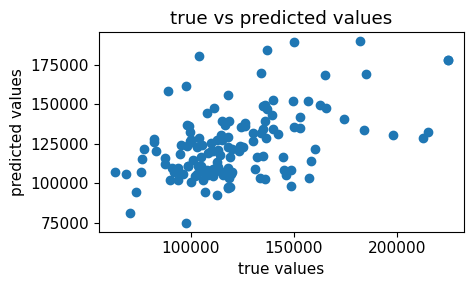

final RMSE: 27505.956952280663
final R2: 0.16955680543834717


In [ ]:
RMSE, R2, best_rf = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, rf_model, rf_params)
print('final RMSE:', RMSE)
print('final R2:', R2)

# Support Vector Machine

In [ ]:
# RMSE, R2, best_svr = reduced_feature(df_train, y_train, df_CV, y_CV, df_test, y_test, svr_model, svr_params)
# print('final RMSE:', RMSE)
# print('final R2:', R2)

there are 3 unique missing value patterns.
working on unique pattern 0


# Baseline scores

In [ ]:
# calculate baseline rmse
baseline_rmse = np.sqrt(np.mean((y_test - np.mean(y_train))**2))
print('Baseline model RMSE:', baseline_rmse)
print('Baseline model R2:', r2_score(y_test, [np.mean(y_train)]*len(y_test)))
print('Test baseline RMSE:', np.sqrt(np.mean((y_test - np.mean(y_test))**2)))
print('Test baseline R2:', r2_score(y_test, [np.mean(y_test)]*len(y_test)))

print('Standard deviation of y_test:', np.std(y_test))

Baseline model RMSE: 32427.074243495197
Baseline model R2: -0.15417574745066975
Test baseline RMSE: 30183.652604522355
Test baseline R2: 0.0
Standard deviation of y_test: 30183.652604522355


# Global features importance

In [ ]:
print(best_elastic)

[ElasticNet(alpha=1000.0, l1_ratio=1.0), ElasticNet(alpha=1000.0, l1_ratio=1.0), ElasticNet(alpha=1000.0, l1_ratio=1.0)]
